<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/notebooks/06_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

### Data

⚠️ **NOTE:** Kaggle files have already been uploaded to the repo. You find them in folder `kaggle_data`´

If you for any reason need to download data from kaggle, instructions are in one of the [optional notebooks](./88_kaggle_data.ipynb) : <a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/notebooks/88_kaggle_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/STASYA00/IAAC2024_tutorials
%cd IAAC2024_tutorials/notebooks

In [132]:
# importing the necessary packages
import calendar
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

In [358]:
metadata = pd.read_csv("../kaggle_data/tutorial_results/04_metadata.csv", index_col=0)
train = pd.read_csv("../kaggle_data/train.csv", index_col=0)
metadata.head()

building_id  site_id  primaryspaceusage  sub_primaryspaceusage     sqm  \
136          432        3                  0                      2  4703.0   
137          416        3                  0                      2   499.3   
138          436        3                  0                      2  9061.0   
139          441        3                  0                      3  7579.0   
140          442        3                  0                      3  5295.0   

     timezone  electricity  hotwater  water  gas  industry  subindustry  \
136         1            0         0      0    0         0            2   
137         1            0         1      0    0         0            2   
138         1            0         0      0    0         0            2   
139         1            0         0      0    0         0            2   
140         1            0         1      0    0         0            2   

     heatingtype  yearbuilt  numberoffloors  occupants  rating  
136           11        0.0             5.0      378.9     1.0  
137            7        0.0             4.0      104.8     0.0  
138            7     2005.0            10.0      523.2     2.0  
139            7     1913.0             5.0      517.9     0.0  
140            7     1953.0             6.0      378.9     1.0

In [359]:
full_df = train.merge(metadata, on='building_id', how='left')
full_df.head()

building_id         day  meter  meter_reading  site_id  primaryspaceusage  \
0            2  2016-02-02    595          102.6        0                  1   
1            2  2016-02-02    207            0.3        0                  1   
2            2  2016-02-03    595           88.8        0                  1   
3            2  2016-02-03    207            0.1        0                  1   
4            2  2016-02-04    595           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  hotwater  water  gas  \
0                      4  811.0         1            0         0      0    1   
1                      4  811.0         1            0         0      0    1   
2                      4  811.0         1            0         0      0    1   
3                      4  811.0         1            0         0      0    1   
4                      4  811.0         1            0         0      0    1   

   industry  subindustry  heatingtype  yearbuilt  numberoffloors  occupants  \
0         1            9            5     1976.0             1.0       20.6   
1         1            9            5     1976.0             1.0       20.6   
2         1            9            5     1976.0             1.0       20.6   
3         1            9            5     1976.0             1.0       20.6   
4         1            9            5     1976.0             1.0       20.6   

   rating  
0     3.0  
1     3.0  
2     3.0  
3     3.0  
4     3.0

In [360]:
full_df["sub_primaryspaceusage"].value_counts()

sub_primaryspaceusage
20    100009
18     47775
2      27391
4      25480
3      17199
15      8918
7       7644
21      3822
8       3185
11      3185
10      3185
9       2548
12      1911
13      1911
23      1911
5       1274
1       1274
24      1274
22      1274
17      1274
0        637
16       637
25       637
19       637
14       637
6        637
Name: count, dtype: int64

In [361]:
full_df["day"] = full_df["day"].apply(lambda s: datetime.strptime(s, "%Y-%m-%d"))
full_df["year"] = full_df["day"].apply(lambda s: s.year)
full_df["month"] = full_df["day"].apply(lambda s: s.month)
full_df["day_number"] = full_df["day"].apply(lambda s: s.day)
full_df["weekday"] = full_df["day"].apply(lambda s: s.weekday() in [5,6])

In [362]:
target = "meter_reading"
meter_dict = {595:0, 207:1, 649:2, 413:3}
full_df["meter"].replace(meter_dict, inplace=True)
X = full_df.drop(columns=[target]).loc[full_df[target].isna()==False]
Y = full_df[target].loc[full_df[target].isna()==False]


## 🏡 Buildings' Efficiency - Time Series and (Finally) Predictions

#### 🫧 EDA

##### 🪸 Daily consumption in one building by meter

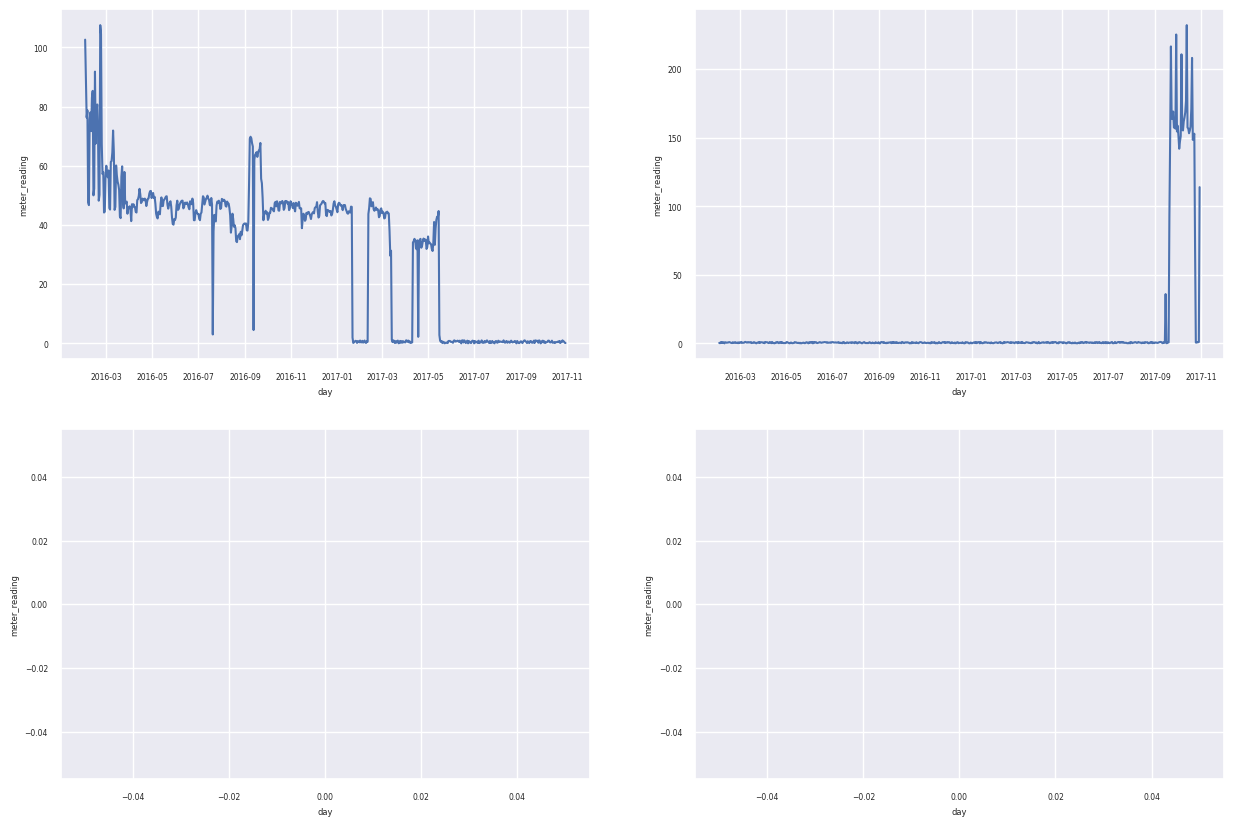

In [53]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==i], 
                 x="day", y=target, ax=axes[int(i/2)][i%2])

##### 🪸 Monthly consumption in one building

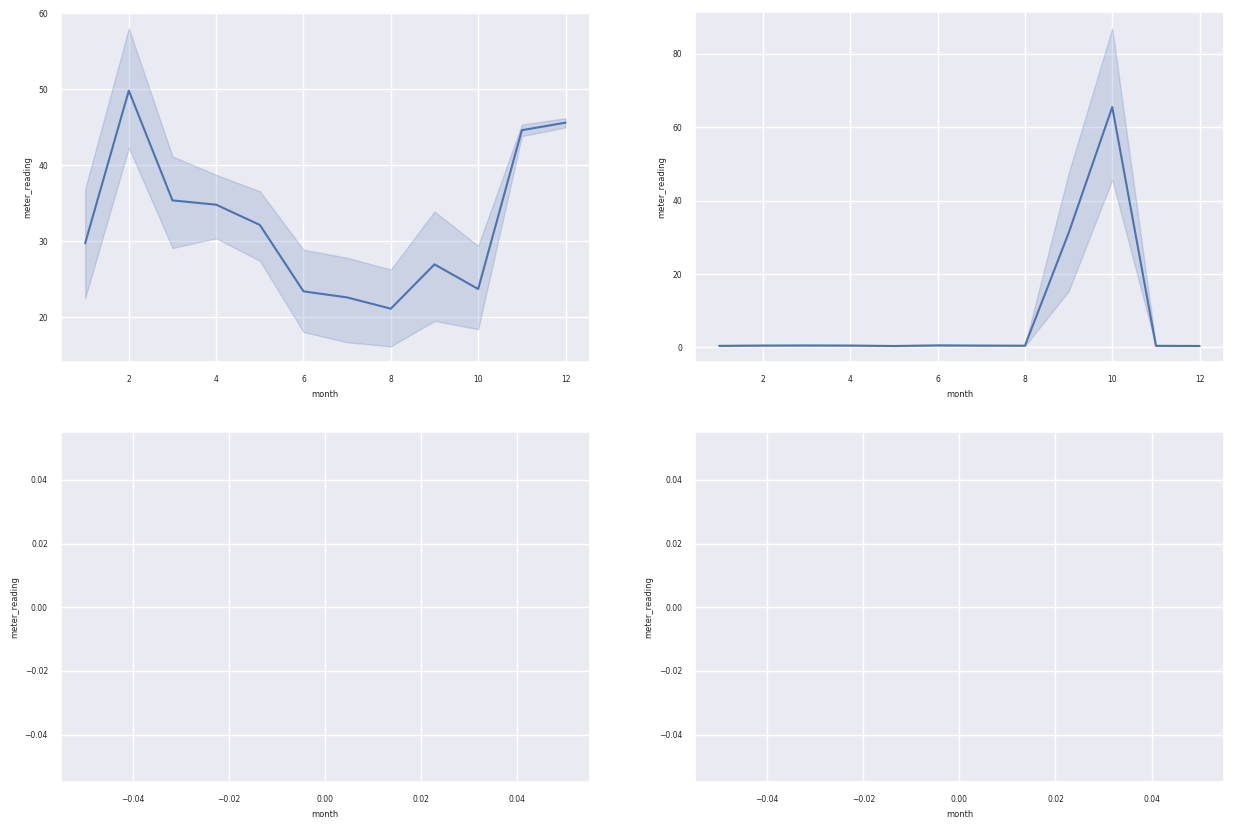

In [8]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==i], 
                 x="month", y=target, ax=axes[int(i/2)][i%2])

##### 🪸 Daily consumption in one building by month

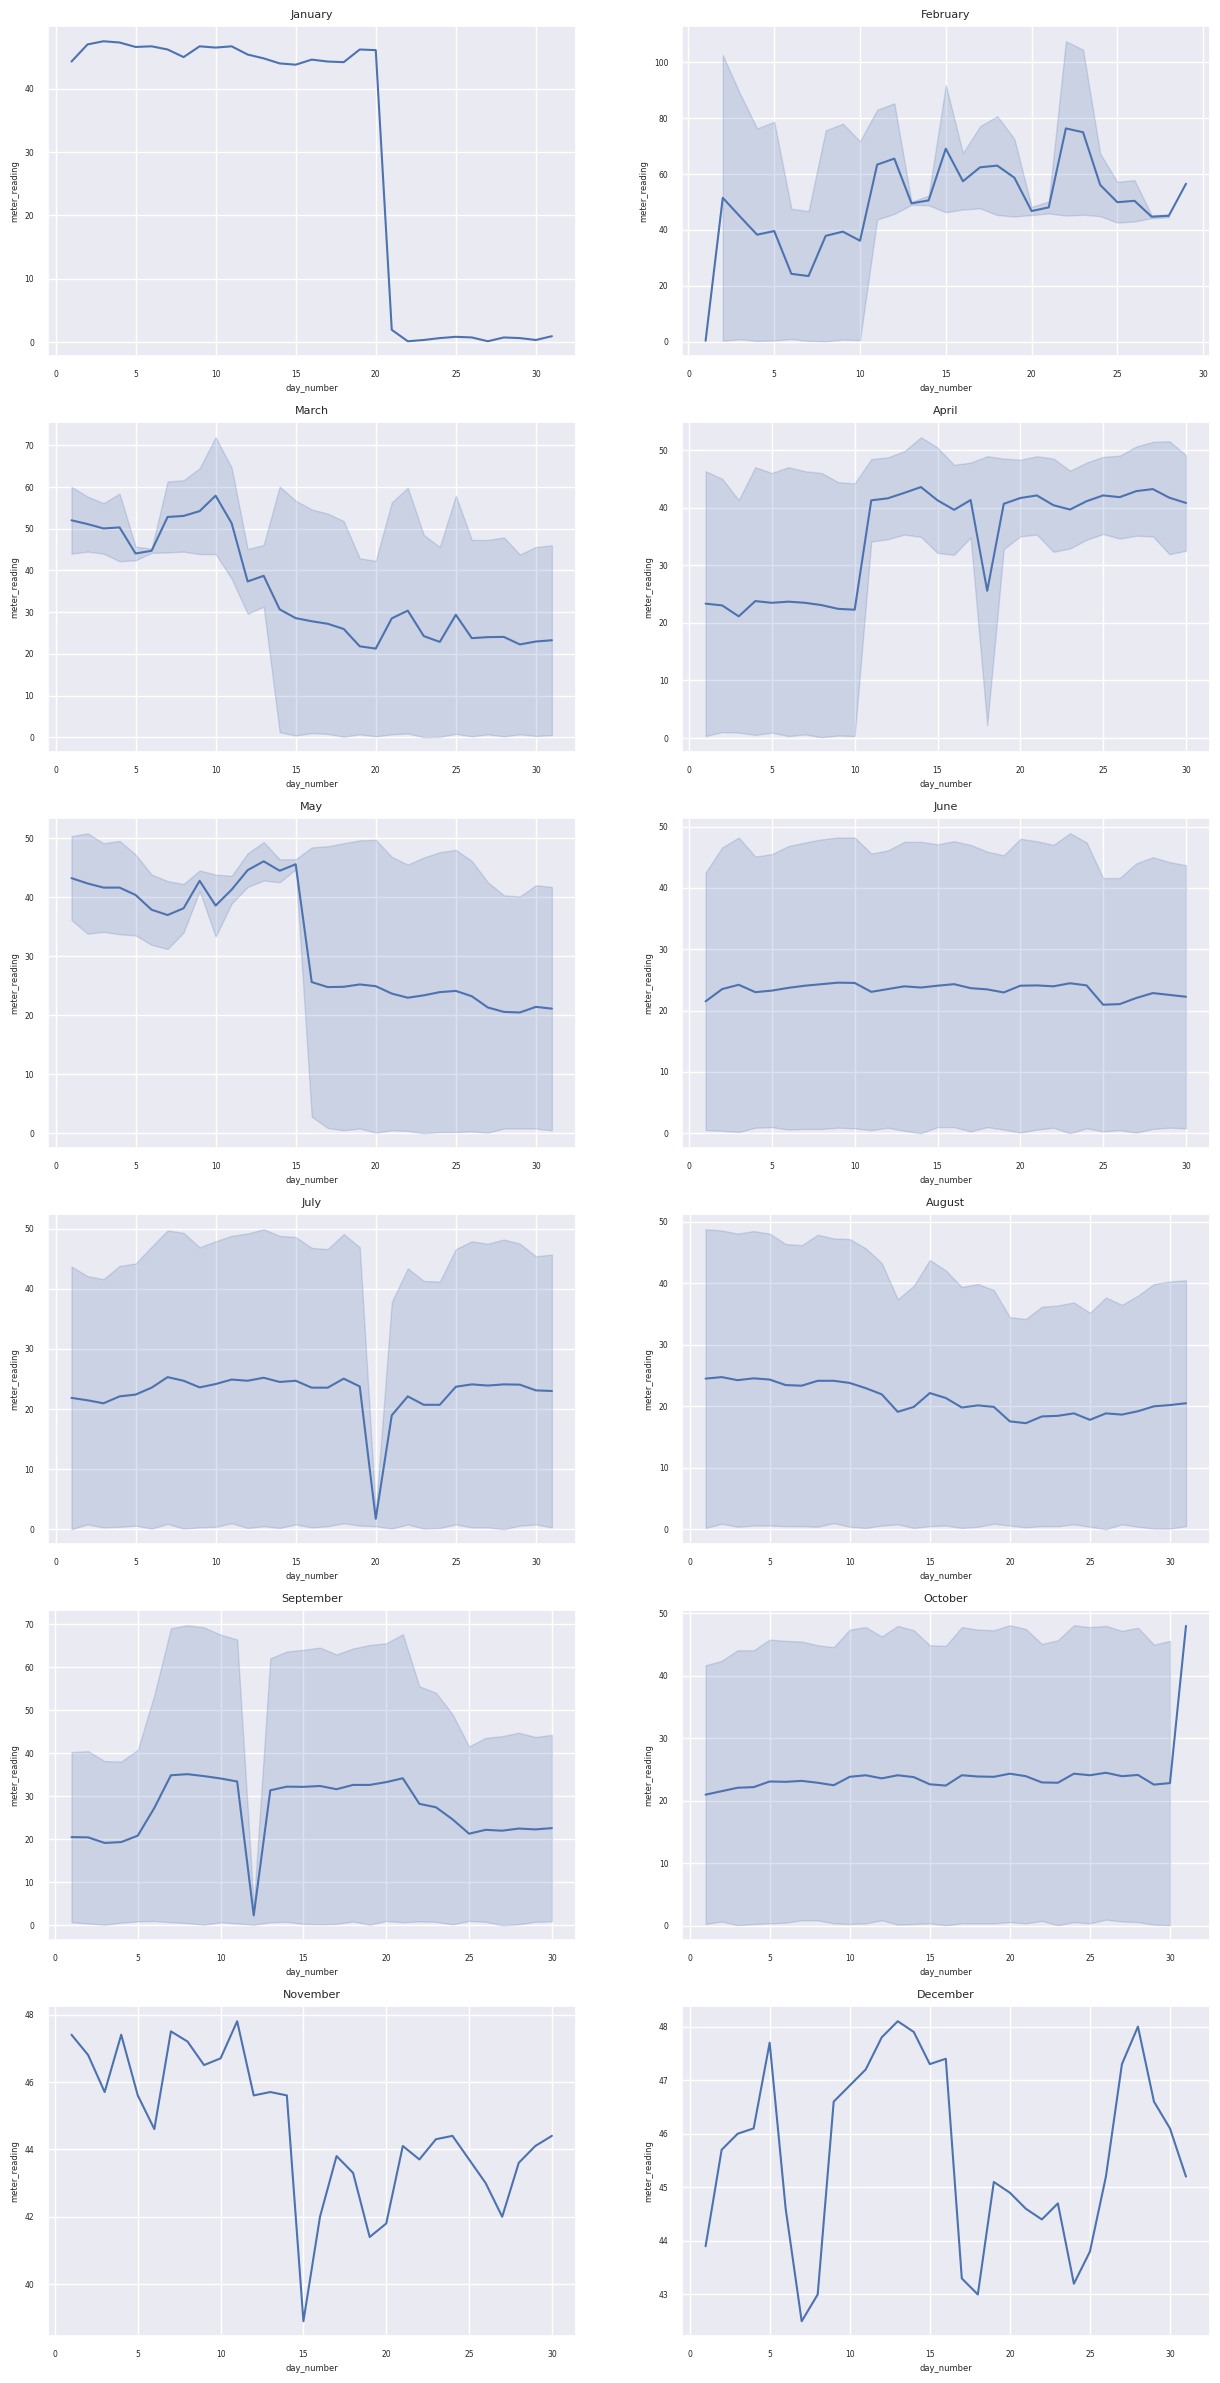

In [9]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(6, 2, figsize=(15, 30))
for i in range(12):
    sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==0].loc[full_df["month"]==i+1], 
                 x="day_number", y=target, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_title(calendar.month_name[i+1], fontsize=8)

##### 🪸 Daily electricity consumption in a group of buildings with the same space usage

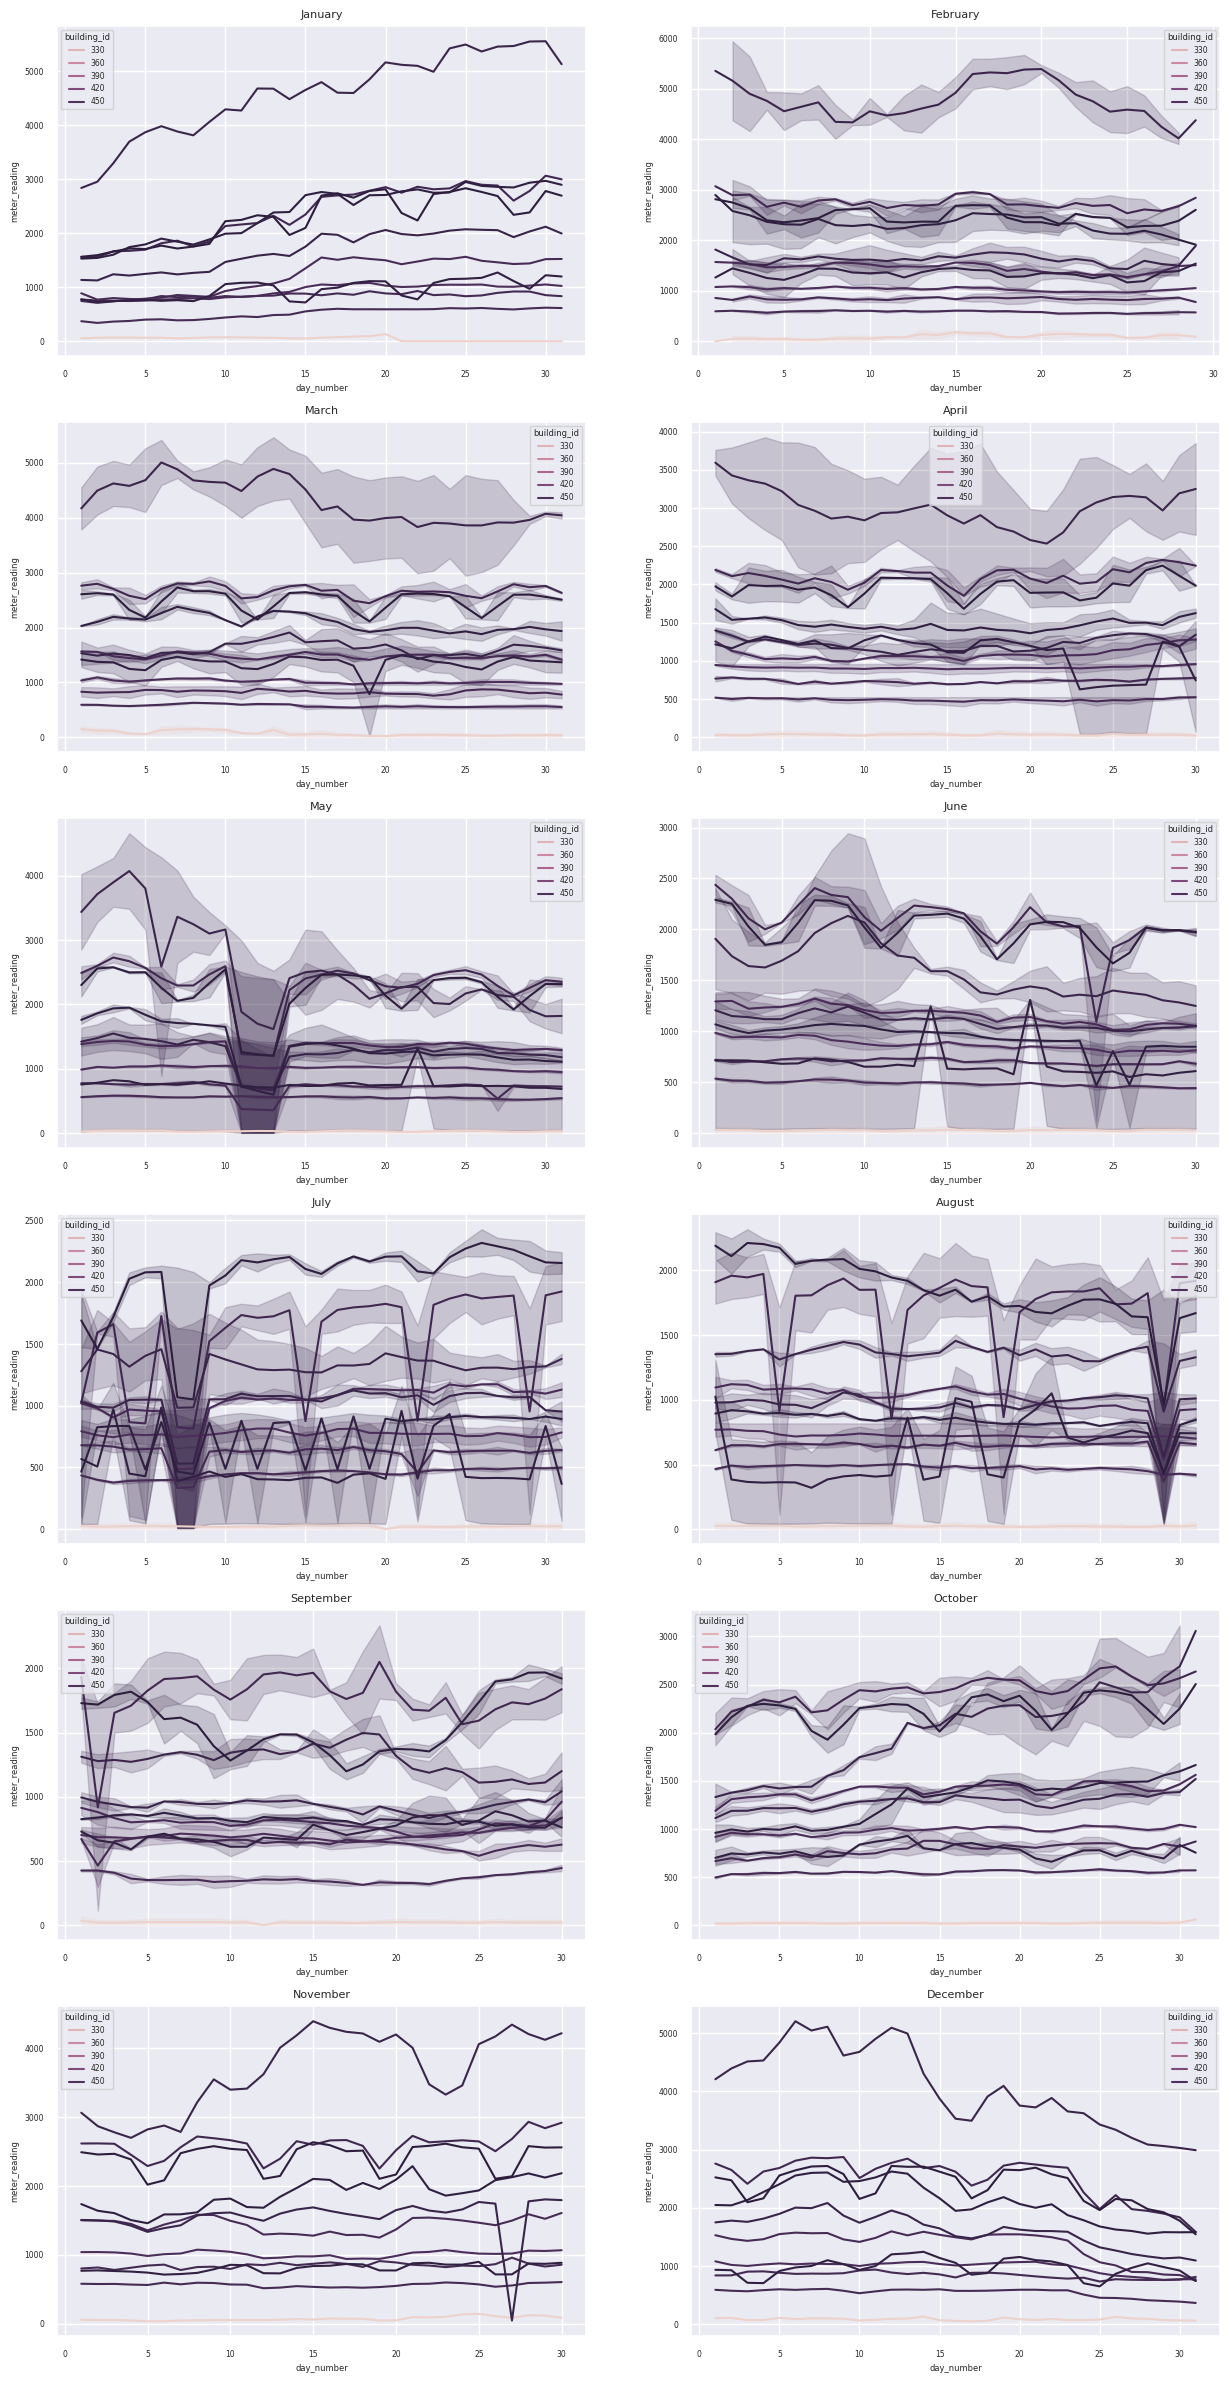

In [15]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(6, 2, figsize=(15, 30))
for i in range(12):
    sns.lineplot(data=full_df.loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==i+1], 
                 x="day_number", y=target, hue="building_id", ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_title(calendar.month_name[i+1], fontsize=8)

##### 🧩 Task I - Finding patterns in groups

Look at combinations of columns and aggregation levels that you think could be significant for resolving this problem. Plot your visualizations and discuss the patterns.

In [ ]:
# Your code here

##### ⚙️ Hint

In [ ]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
NUMBER_OF_PLOT_ROWS = 6
NUMBER_OF_PLOT_COLS = 2

# play with the values
COLUMN1 = ""
FILTER1 = ""
COLUMN2 = ""
FILTER2 = ""
HUE = ""

fig, axes = plt.subplots(NUMBER_OF_PLOT_ROWS, NUMBER_OF_PLOT_COLS, figsize=(30 / NUMBER_OF_PLOT_ROWS, 5 * NUMBER_OF_PLOT_ROWS))

for i in range(NUMBER_OF_PLOT_ROWS * NUMBER_OF_PLOT_COLS):

    sns.lineplot(data=full_df.loc[full_df[COLUMN1]==FILTER1]
                            .loc[full_df["meter"]==0]  # or other meters
                            .loc[full_df["month"]==i+1], # plot by month

                            x="day_number", # or week or month, depending on your aggregation level
                            y=target, 
                            hue=HUE, 
                            ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_title(calendar.month_name[i+1], fontsize=8)

### 🫧 Autoregression

Let's first write a function to split time data in one line:

In [319]:
def split_time_data(df:pd.DataFrame):
    _df = df.sort_values(by=["day"])
    split_percent = 0.8

    X = _df.drop(columns=[target]).loc[_df[target].isna()==False]
    Y = _df[target].loc[_df[target].isna()==False]

    X_train = X[:int(X.shape[0] * split_percent)].drop(columns=["day"])
    X_valid = X[int(X.shape[0] * split_percent):].drop(columns=["day"])
    Y_train = Y[:int(X.shape[0] * split_percent)]
    Y_valid = Y[int(X.shape[0] * split_percent):]

    return X_train, X_valid, Y_train, Y_valid


In [322]:
X_train, X_valid, Y_train, Y_valid = split_time_data(full_df)

In [323]:
model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.5701938820640715


##### 🪸 Shifts

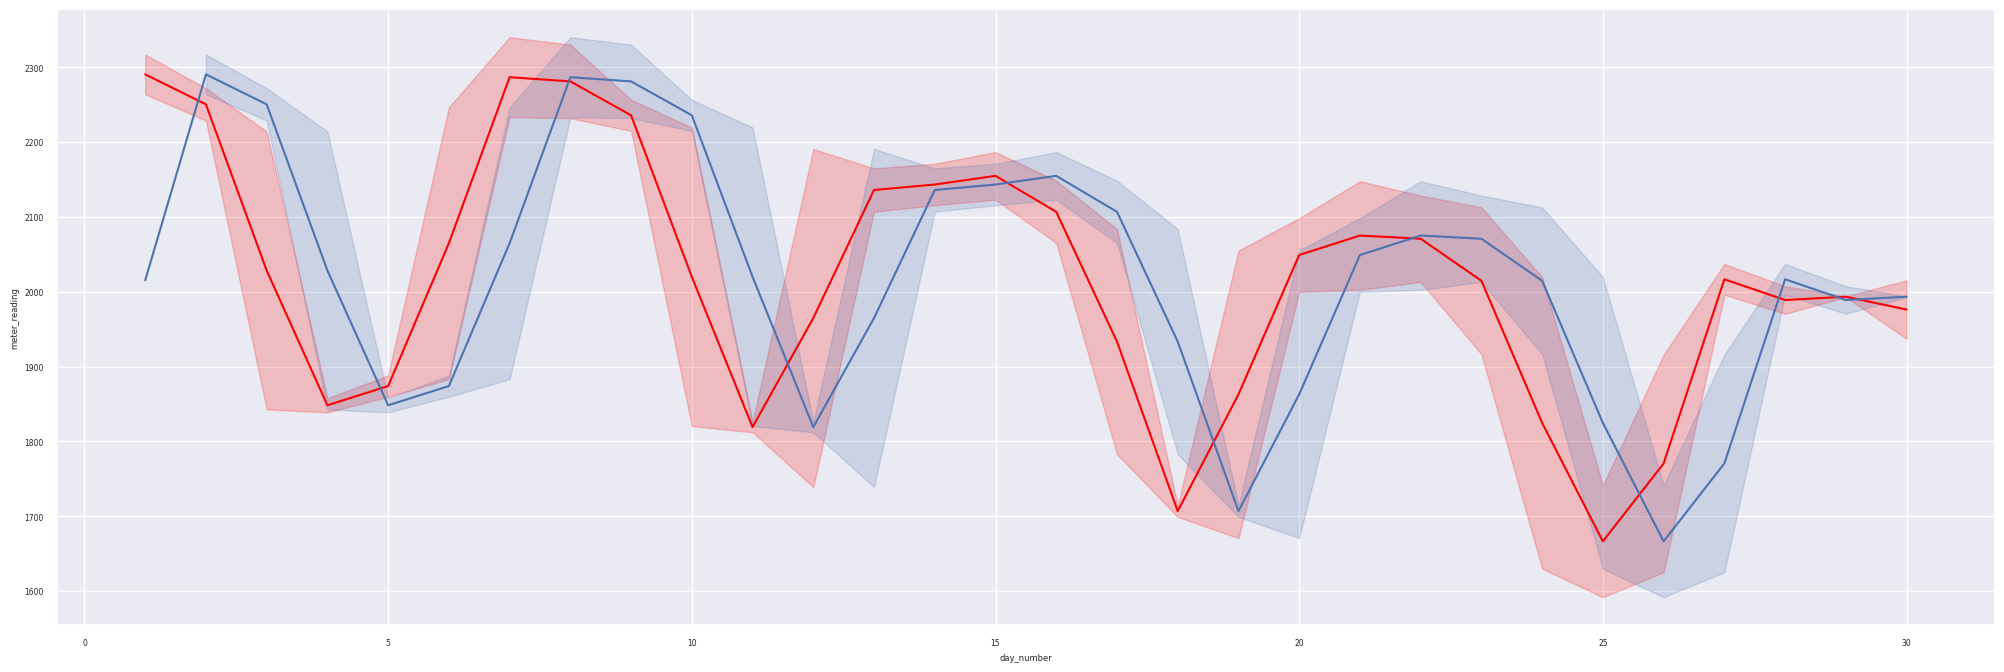

In [56]:
# shifting the line with 1 day
BID = 473
ax = sns.lineplot(x=full_df["day_number"].loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], 
                y=Y_train.shift(0).loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], color=(1,0,0))

_ = sns.lineplot(x=full_df["day_number"].loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], 
             y=Y_train.loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID].shift(1), ax=ax)

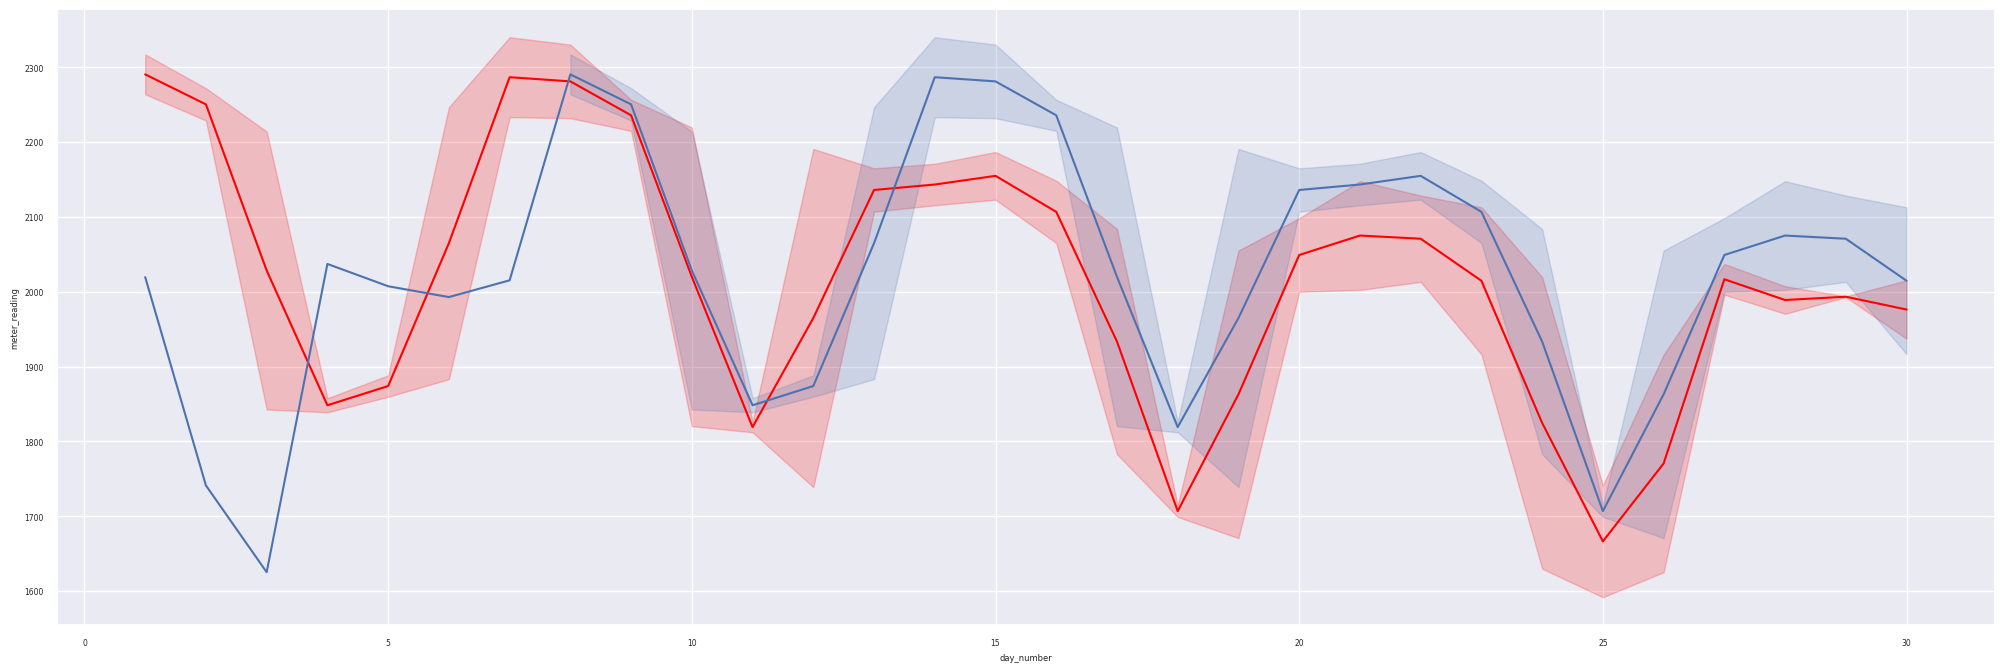

In [57]:
# shifting the line with 1 week
BID = 473
ax = sns.lineplot(x=full_df["day_number"].loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], 
                y=Y_train.shift(0).loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], color=(1,0,0))

_ = sns.lineplot(x=full_df["day_number"].loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID], 
             y=Y_train.loc[full_df["sub_primaryspaceusage"]==7].loc[full_df["meter"]==0].loc[full_df["month"]==6].loc[full_df["building_id"]==BID].shift(7), ax=ax)

Compare:

In [58]:
print(Y_train.shift(1).head() )

0      NaN
1    102.6
2      0.3
3     88.8
4      0.1
Name: meter_reading, dtype: float64


In [59]:
print(Y_train.shift(2).head())

0      NaN
1      NaN
2    102.6
3      0.3
4     88.8
Name: meter_reading, dtype: float64


##### Adding one shift to dataframe

In [60]:
X_train_lags = pd.concat([X_train, pd.DataFrame(Y_train.shift(1))], ignore_index=True, axis=1).fillna(0)
X_valid_lags = pd.concat([X_valid, pd.DataFrame(Y_valid.shift(1))], ignore_index=True, axis=1).fillna(0)

In [62]:
model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train_lags, Y_train)
score = model.score(X_valid_lags, Y_valid)
print(score)

-0.0076767830502966206


🚫🚫🚫 **BUT**

Our data is not consequent. Right now we have many building ids, meters and so on. If we simply shift data by 1 (or more) we would get input from other buildings or meteres, probably from the same day. For one building and one meter it would work though, but we have too few samples. \
Let's write a function that would return the predictions from given building, given meter for the previous day:

In [262]:
full_df_sorted = full_df.sort_values(by=["building_id", "meter", "day"])

full_df_sorted.head(15)

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0             2 2016-02-02      0          102.6        0                  1   
2             2 2016-02-03      0           88.8        0                  1   
4             2 2016-02-04      0           76.3        0                  1   
6             2 2016-02-05      0           78.7        0                  1   
8             2 2016-02-06      0           47.6        0                  1   
10            2 2016-02-07      0           46.7        0                  1   
12            2 2016-02-08      0           75.6        0                  1   
14            2 2016-02-09      0           78.0        0                  1   
16            2 2016-02-10      0           71.7        0                  1   
18            2 2016-02-11      0           83.0        0                  1   
20            2 2016-02-12      0           85.3        0                  1   
22            2 2016-02-13      0           50.0        0                  1   
24            2 2016-02-14      0           52.3        0                  1   
26            2 2016-02-15      0           91.8        0                  1   
28            2 2016-02-16      0           67.5        0                  1   

    sub_primaryspaceusage    sqm  timezone  electricity  ...  year  month  \
0                       4  811.0         1            0  ...  2016      2   
2                       4  811.0         1            0  ...  2016      2   
4                       4  811.0         1            0  ...  2016      2   
6                       4  811.0         1            0  ...  2016      2   
8                       4  811.0         1            0  ...  2016      2   
10                      4  811.0         1            0  ...  2016      2   
12                      4  811.0         1            0  ...  2016      2   
14                      4  811.0         1            0  ...  2016      2   
16                      4  811.0         1            0  ...  2016      2   
18                      4  811.0         1            0  ...  2016      2   
20                      4  811.0         1            0  ...  2016      2   
22                      4  811.0         1            0  ...  2016      2   
24                      4  811.0         1            0  ...  2016      2   
26                      4  811.0         1            0  ...  2016      2   
28                      4  811.0         1            0  ...  2016      2   

    day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  \
0            2    False          8.3         12.0     10.529167   
2            3    False          5.1         12.8     10.341667   
4            4    False          3.2         10.8      7.808333   
6            5    False         10.1         12.0     10.991667   
8            6     True          5.9          9.7      7.204167   
10           7     True          6.1         11.8      9.662500   
12           8    False          9.1         12.5     10.975000   
14           9    False          5.9          9.9      7.708333   
16          10    False          4.3          9.7      6.620833   
18          11    False          6.0         11.0      9.550000   
20          12    False          8.3         11.7      9.850000   
22          13     True          6.8         11.9      9.179167   
24          14     True          5.1         10.9      7.754167   
26          15    False          6.0          8.9      8.054167   
28          16    False          3.1          7.4      5.441667   

    windspeed_min  windspeed_max  windspeed_mean  
0             3.2           10.2        7.066667  
2             4.7            9.5        6.958333  
4             3.1            9.5        6.258333  
6             7.2           13.8       10.029167  
8             4.7            9.6        7.608333  
10            3.2           12.3        8.175000  
12            8.7           12.7       10.516667  
14       

In [324]:
_lags = pd.DataFrame(full_df_sorted[target].shift(1))
_lags.rename(lambda s: "lag_1", axis='columns', inplace=True)
full_df_sorted_lags = pd.concat([full_df_sorted, _lags], axis=1)

"""
Since we have changed the order of the rows, all the buildings except for the first one will get the input from another building on the first day.
Let's fix it and assign a missing value to the first day lag:
"""
full_df_sorted_lags.loc[full_df_sorted_lags["day"]==full_df_sorted_lags["day"][0], "lag_1"] = 0
full_df_sorted_lags.head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
4            2 2016-02-04      0           76.3        0                  1   
6            2 2016-02-05      0           78.7        0                  1   
8            2 2016-02-06      0           47.6        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  month  \
0                      4  811.0         1            0  ...      2   
2                      4  811.0         1            0  ...      2   
4                      4  811.0         1            0  ...      2   
6                      4  811.0         1            0  ...      2   
8                      4  811.0         1            0  ...      2   

   day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  windspeed_min  \
0           2    False          8.3         12.0     10.529167            3.2   
2           3    False          5.1         12.8     10.341667            4.7   
4           4    False          3.2         10.8      7.808333            3.1   
6           5    False         10.1         12.0     10.991667            7.2   
8           6     True          5.9          9.7      7.204167            4.7   

   windspeed_max  windspeed_mean  lag_1  
0           10.2        7.066667    0.0  
2            9.5        6.958333  102.6  
4            9.5        6.258333   88.8  
6           13.8       10.029167   76.3  
8            9.6        7.608333   78.7  

[5 rows x 31 columns]

In [325]:
# reversing the sorting order back to the original one:
full_df_sorted_lags = full_df_sorted_lags.sort_index(axis=0)
full_df_sorted_lags.head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  month  \
0                      4  811.0         1            0  ...      2   
1                      4  811.0         1            0  ...      2   
2                      4  811.0         1            0  ...      2   
3                      4  811.0         1            0  ...      2   
4                      4  811.0         1            0  ...      2   

   day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  windspeed_min  \
0           2    False          8.3         12.0     10.529167            3.2   
1           2    False          8.3         12.0     10.529167            3.2   
2           3    False          5.1         12.8     10.341667            4.7   
3           3    False          5.1         12.8     10.341667            4.7   
4           4    False          3.2         10.8      7.808333            3.1   

   windspeed_max  windspeed_mean  lag_1  
0           10.2        7.066667    0.0  
1           10.2        7.066667    0.0  
2            9.5        6.958333  102.6  
3            9.5        6.958333    0.3  
4            9.5        6.258333   88.8  

[5 rows x 31 columns]

In [320]:
# Repeating the procedure:

X_train, X_valid, Y_train, Y_valid = split_time_data(full_df_sorted_lags)

In [321]:
model = RandomForestRegressor(n_estimators=10).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.6666745212120183


##### Adding several shifts to dataframe

Let's write a function to simplify shifts generation:

In [342]:
def make_shifts(df, shifts=3):
    _df_sorted = df.sort_values(by=["building_id", "meter", "day"])
    _lags = pd.DataFrame({"lag_{}".format(i): _df_sorted[target].shift(i+1) for i in range(shifts)})
    _df_sorted_lags = pd.concat([_df_sorted, _lags], axis=1)

    """
    Since we have changed the order of the rows, all the buildings except for the first one will get the input from another building on the first day.
    Let's fix it and assign a missing value to the first day lag:
    """
    for i in range(shifts):
        for j in range(0, i+1):
            _df_sorted_lags.loc[_df_sorted_lags["day"]==_df_sorted_lags["day"]- timedelta(days=int(j)), "lag_{}".format(i)] = 0

    _df_sorted_lags = _df_sorted_lags.sort_index(axis=0)
    return _df_sorted_lags

In [343]:
df7 = make_shifts(full_df, 7)
X_train, X_valid, Y_train, Y_valid = split_time_data(df7)

In [344]:
df7.head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  windspeed_min  \
0                      4  811.0         1            0  ...            3.2   
1                      4  811.0         1            0  ...            3.2   
2                      4  811.0         1            0  ...            4.7   
3                      4  811.0         1            0  ...            4.7   
4                      4  811.0         1            0  ...            3.1   

   windspeed_max  windspeed_mean  lag_0  lag_1  lag_2  lag_3  lag_4  lag_5  \
0           10.2        7.066667    0.0    0.0    0.0    0.0    0.0    0.0   
1           10.2        7.066667    0.0    0.0    0.0    0.0    0.0    0.0   
2            9.5        6.958333    0.0    0.0    0.0    0.0    0.0    0.0   
3            9.5        6.958333    0.0    0.0    0.0    0.0    0.0    0.0   
4            9.5        6.258333    0.0    0.0    0.0    0.0    0.0    0.0   

   lag_6  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

[5 rows x 37 columns]

In [346]:
model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.5470262134128991


#### 🧩 Task II - Different shifts

Try different shifts and different amount of shifts and check the model performance.

In [347]:
# Your code here

### Weather data

![weather illustration](https://images.unsplash.com/photo-1544085311-11a028465b03?q=80&w=2664&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)

#### Weather data processing

In [348]:
weather = pd.read_csv("../kaggle_data/weather.csv", index_col=0)
weather.head()

timestamp  site_id  airTemperature  cloudCoverage  \
18121  2016-02-01 01:00:00  Trapano            11.3            0.9   
18122  2016-02-01 02:00:00  Trapano            12.3            0.6   
18123  2016-02-01 03:00:00  Trapano            12.1            0.6   
18124  2016-02-01 04:00:00  Trapano            12.4            0.7   
18125  2016-02-01 05:00:00  Trapano            11.6            0.5   

       dewTemperature  precipDepth1HR  precipDepth6HR  seaLvlPressure  \
18121            10.5             NaN             NaN          1024.0   
18122            10.8             NaN             NaN          1023.8   
18123             9.7             NaN             NaN          1022.7   
18124             9.8             NaN             NaN          1021.8   
18125             9.3             NaN             NaN          1021.6   

       windDirection  windSpeed  
18121          160.5        3.4  
18122          170.8        5.2  
18123          180.2        5.1  
18124          160.1        5.4  
18125          170.1        5.1

In [349]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
weather["site_id"] = le.fit_transform(weather["site_id"]).astype(int)
weather["day"] = weather["timestamp"]
weather["day"] = pd.to_datetime(weather["day"])
weather.drop(columns=["timestamp"], inplace=True)

In [350]:
full_df.merge(weather, how="left", on=["day", "site_id"]).head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  windspeed_max  \
0                      4  811.0         1            0  ...           10.2   
1                      4  811.0         1            0  ...           10.2   
2                      4  811.0         1            0  ...            9.5   
3                      4  811.0         1            0  ...            9.5   
4                      4  811.0         1            0  ...            9.5   

   windspeed_mean  airTemperature  cloudCoverage  dewTemperature  \
0        7.066667             8.9            0.7             6.5   
1        7.066667             8.9            0.7             6.5   
2        6.958333            12.3            NaN            10.2   
3        6.958333            12.3            NaN            10.2   
4        6.258333             5.6            0.1             2.8   

   precipDepth1HR  precipDepth6HR  seaLvlPressure  windDirection  windSpeed  
0             NaN             NaN             NaN          230.8        4.4  
1             NaN             NaN             NaN          230.8        4.4  
2             NaN             NaN             NaN          220.2        5.9  
3             NaN             NaN             NaN          220.2        5.9  
4             NaN             NaN             NaN          290.7        5.3  

[5 rows x 38 columns]

Doesn't work exactly as we want, right. What could be the issue?

We have some discrepancy in data. Weather table has datetime by **hour** while our main table has datetime by **day**. We would need to aggregate the data in the ``weather`` table so that it corresponds to the main table.\
It could be done in the following ways:\
* getting average value per day
* getting min value per day
* getting max value per day
* generating a column for each hour of each day (an overkill)
* getting other stats (variance, std, median) per day
* comparing values with the previous days
* ...

Let's look at how we get the first three on example of site_id ```0``` for ```airTemperature``` and ```windSpeed```:

In [351]:
site_id = 0
w_stats_0 = weather.loc[weather["site_id"]==site_id].set_index("day").resample('D')[['airTemperature',
                                                                       "windSpeed"]].agg(['min', 'max', "mean"]).to_records()
w_stats_df_0 = pd.DataFrame(w_stats_0) 

Let's take a look at what we have:

In [352]:
# first 5 rows of w_stats_0, aka records
w_stats_0[:5]

rec.array([('2016-02-01T00:00:00.000000000',  8.2, 14.9, 10.84782609, 2. , 10.1,  5.93913043),
           ('2016-02-02T00:00:00.000000000',  8.3, 12. , 10.52916667, 3.2, 10.2,  7.06666667),
           ('2016-02-03T00:00:00.000000000',  5.1, 12.8, 10.34166667, 4.7,  9.5,  6.95833333),
           ('2016-02-04T00:00:00.000000000',  3.2, 10.8,  7.80833333, 3.1,  9.5,  6.25833333),
           ('2016-02-05T00:00:00.000000000', 10.1, 12. , 10.99166667, 7.2, 13.8, 10.02916667)],
          dtype=[('day', '<M8[ns]'), ("('airTemperature', 'min')", '<f8'), ("('airTemperature', 'max')", '<f8'), ("('airTemperature', 'mean')", '<f8'), ("('windSpeed', 'min')", '<f8'), ("('windSpeed', 'max')", '<f8'), ("('windSpeed', 'mean')", '<f8')])

In [353]:
# dataframe with the aggregated statistics for one site_id only
print("Shape:", w_stats_df_0.shape)
w_stats_df_0.head()

Shape: (699, 7)


day  ('airTemperature', 'min')  ('airTemperature', 'max')  \
0 2016-02-01                        8.2                       14.9   
1 2016-02-02                        8.3                       12.0   
2 2016-02-03                        5.1                       12.8   
3 2016-02-04                        3.2                       10.8   
4 2016-02-05                       10.1                       12.0   

   ('airTemperature', 'mean')  ('windSpeed', 'min')  ('windSpeed', 'max')  \
0                   10.847826                   2.0                  10.1   
1                   10.529167                   3.2                  10.2   
2                   10.341667                   4.7                   9.5   
3                    7.808333                   3.1                   9.5   
4                   10.991667                   7.2                  13.8   

   ('windSpeed', 'mean')  
0               5.939130  
1               7.066667  
2               6.958333  
3               6.258333  
4              10.029167

#### 🧩 Task III - Collecting mean air temperature and wind speed for all site_ids

Let's write a function or a for loop that would repeat this operation for all the site_ids

In [ ]:
site_ids = [] # YOUR CODE HERE INSTEAD OF []

dfs = []

for site_id in site_ids:
    w_stats = {}  # YOUR CODE HERE INSTEAD OF {}
    w_stats_df = pd.DataFrame(w_stats)
    w_stats_df["site_id"] = site_id
    dfs.append(w_stats_df)

w_df = pd.concat(dfs, axis=0)  # concatenating the resulting dataframes to have one

# Look at the results
print("Shape:", w_df.shape)
w_df.head()

#### ⚙️ Solution

In [354]:
site_ids = weather["site_id"].unique()
dfs = []

for site_id in site_ids:
    w_stats = weather.loc[weather["site_id"]==site_id].set_index("day").resample('D')[['airTemperature',
                                                                        "windSpeed"]].agg(['min', 'max', "mean"]).to_records()
    w_stats_df = pd.DataFrame(w_stats)
    w_stats_df["site_id"] = site_id
    dfs.append(w_stats_df)
    
w_df = pd.concat(dfs, axis=0)  # concatenating the resulting dataframes to have one

print("Shape:", w_df.shape)
w_df.head()

Shape: (3495, 8)


day  ('airTemperature', 'min')  ('airTemperature', 'max')  \
0 2016-02-01                        9.1                       14.2   
1 2016-02-02                        6.0                       12.0   
2 2016-02-03                        8.1                       13.9   
3 2016-02-04                        2.4                       10.4   
4 2016-02-05                        9.8                       12.7   

   ('airTemperature', 'mean')  ('windSpeed', 'min')  ('windSpeed', 'max')  \
0                   11.782609                   2.9                  10.4   
1                    9.700000                   2.7                  13.0   
2                   12.004167                   5.8                  13.1   
3                    6.925000                   3.1                  10.7   
4                   11.591667                   9.0                  13.5   

   ('windSpeed', 'mean')  site_id  
0               6.343478        3  
1               8.266667        3  
2               9.887500        3  
3               6.433333        3  
4              10.316667        3

#### 🥳 Combining the dataframes

In [355]:
# checking missing values
w_df.isna().value_counts()

day    ('airTemperature', 'min')  ('airTemperature', 'max')  ('airTemperature', 'mean')  ('windSpeed', 'min')  ('windSpeed', 'max')  ('windSpeed', 'mean')  site_id
False  False                      False                      False                       False                 False                 False                  False      3495
Name: count, dtype: int64

In [363]:
full_df = full_df.merge(w_df, how="left", on=["day", "site_id"])
full_df.head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  year  month  \
0                      4  811.0         1            0  ...  2016      2   
1                      4  811.0         1            0  ...  2016      2   
2                      4  811.0         1            0  ...  2016      2   
3                      4  811.0         1            0  ...  2016      2   
4                      4  811.0         1            0  ...  2016      2   

   day_number  weekday  ('airTemperature', 'min')  ('airTemperature', 'max')  \
0           2    False                        8.3                       12.0   
1           2    False                        8.3                       12.0   
2           3    False                        5.1                       12.8   
3           3    False                        5.1                       12.8   
4           4    False                        3.2                       10.8   

   ('airTemperature', 'mean')  ('windSpeed', 'min')  ('windSpeed', 'max')  \
0                   10.529167                   3.2                  10.2   
1                   10.529167                   3.2                  10.2   
2                   10.341667                   4.7                   9.5   
3                   10.341667                   4.7                   9.5   
4                    7.808333                   3.1                   9.5   

   ('windSpeed', 'mean')  
0               7.066667  
1               7.066667  
2               6.958333  
3               6.958333  
4               6.258333  

[5 rows x 30 columns]

In [364]:
names = ["airtemp_min",
         "airtemp_max",
         "airtemp_mean",
         "windspeed_min",
         "windspeed_max",
         "windspeed_mean"]

_n = {c : n for c, n in zip(full_df.columns[-6:], names)}
full_df = full_df.rename(columns=_n)
full_df.head()

building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  year  month  \
0                      4  811.0         1            0  ...  2016      2   
1                      4  811.0         1            0  ...  2016      2   
2                      4  811.0         1            0  ...  2016      2   
3                      4  811.0         1            0  ...  2016      2   
4                      4  811.0         1            0  ...  2016      2   

   day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  windspeed_min  \
0           2    False          8.3         12.0     10.529167            3.2   
1           2    False          8.3         12.0     10.529167            3.2   
2           3    False          5.1         12.8     10.341667            4.7   
3           3    False          5.1         12.8     10.341667            4.7   
4           4    False          3.2         10.8      7.808333            3.1   

   windspeed_max  windspeed_mean  
0           10.2        7.066667  
1           10.2        7.066667  
2            9.5        6.958333  
3            9.5        6.958333  
4            9.5        6.258333  

[5 rows x 30 columns]

Let's take a look at correlation between the newly added weather features and the target:

##### 🪸 Daily consumption in one building by month

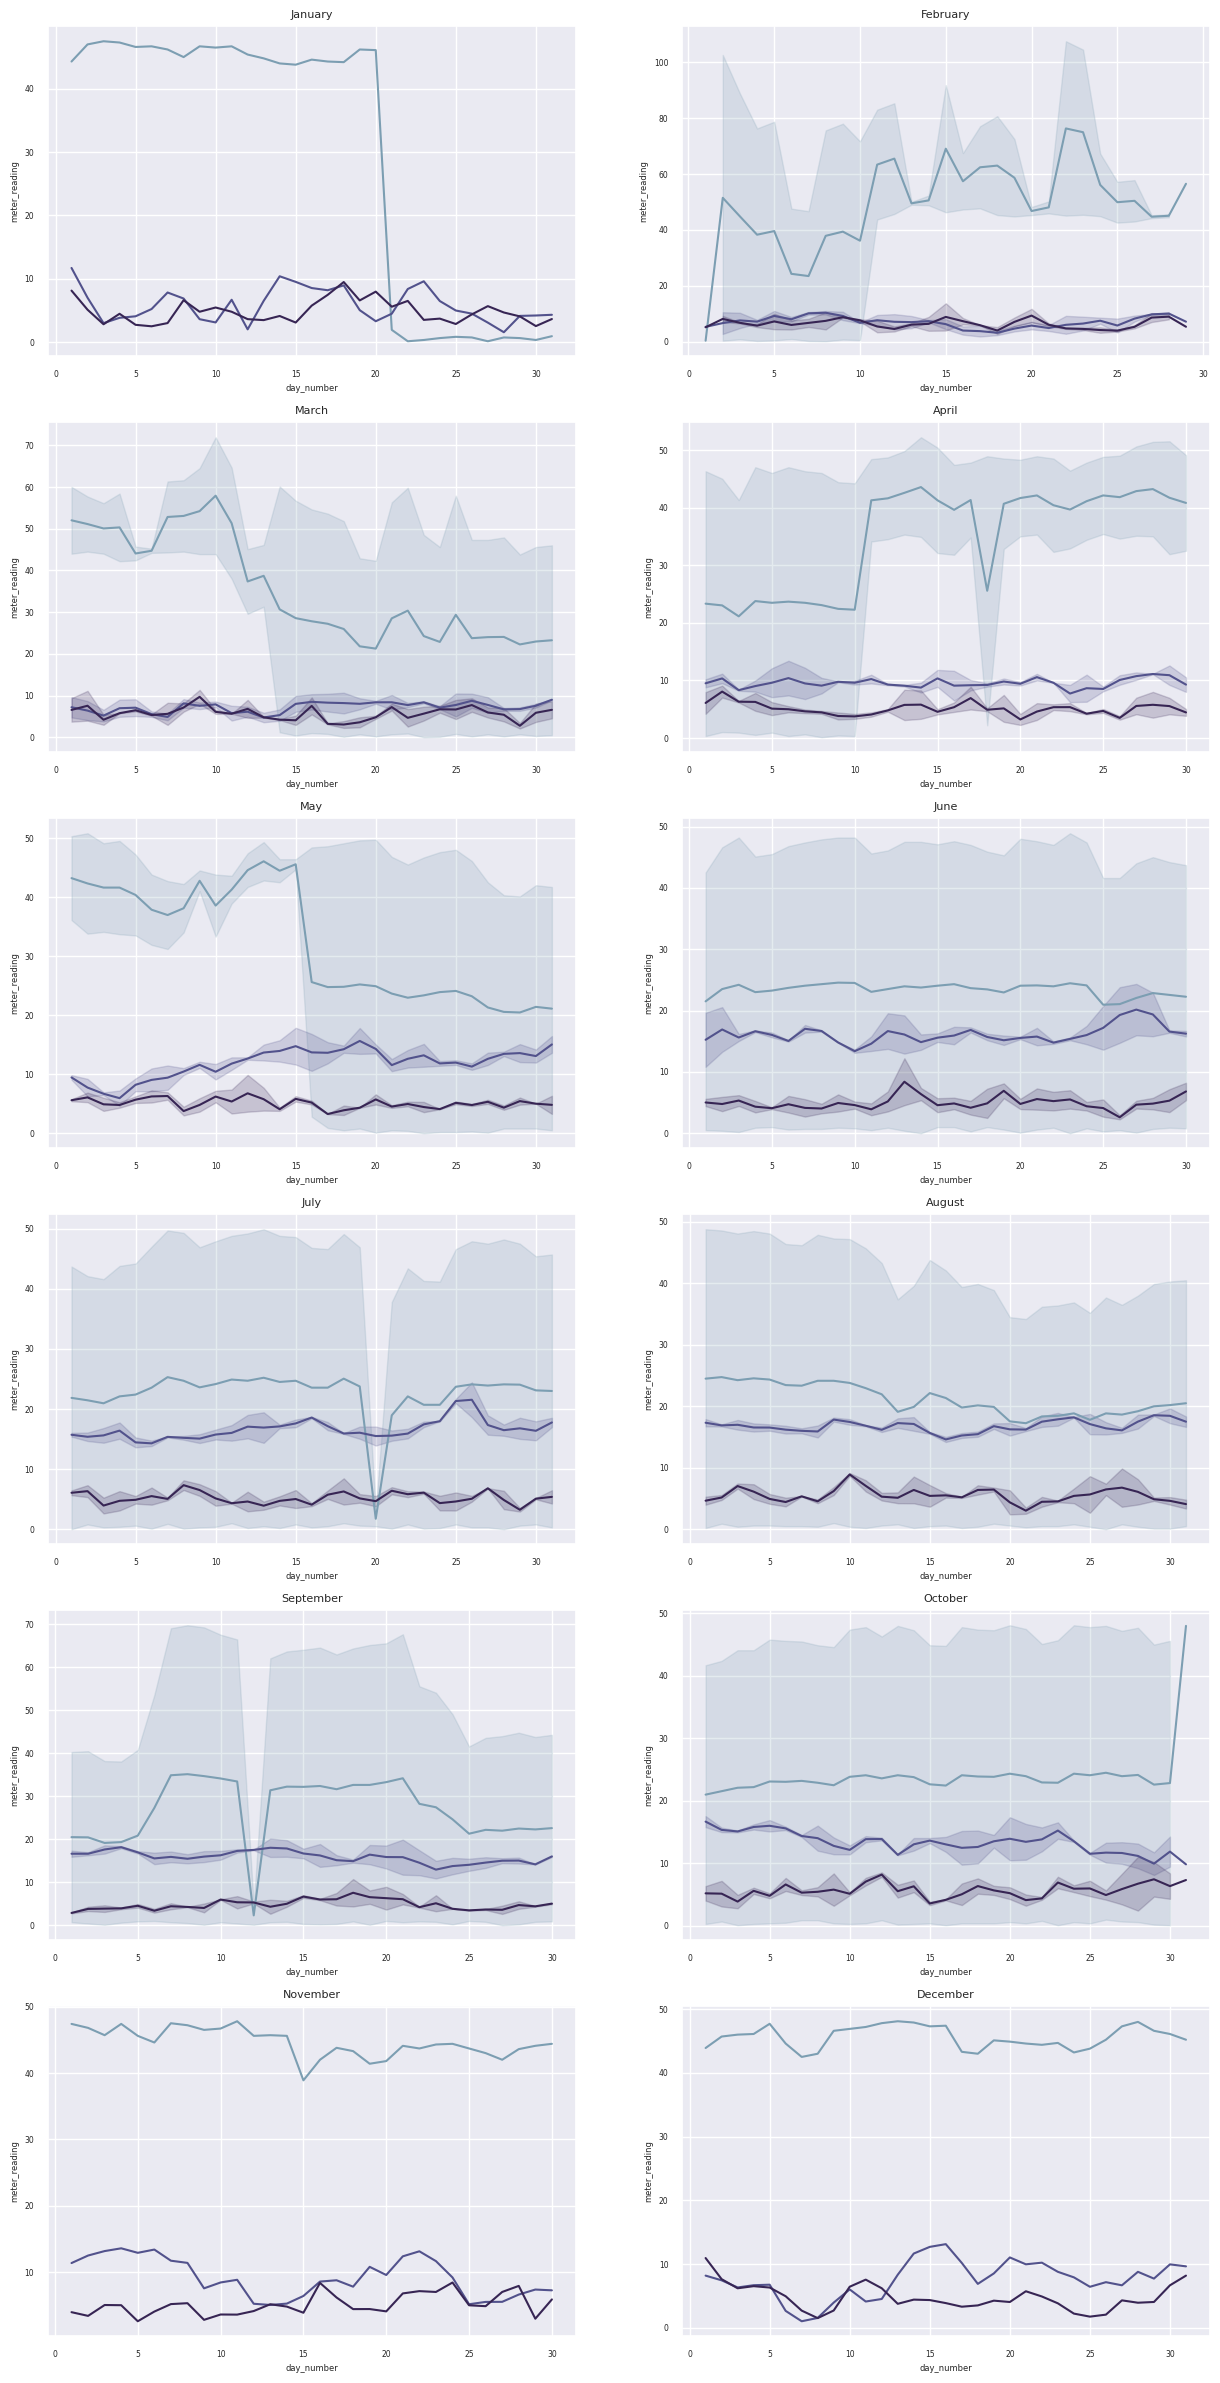

In [84]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(6, 2, figsize=(15, 30))
colors = np.array([
    [124, 158, 178],
    [82,82,140],
    [55,37,84]
])

for i in range(12):
    for j, col in enumerate([target, "airtemp_mean","windspeed_mean"]):
        sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==0].loc[full_df["month"]==i+1], 
                    x="day_number", y=col, ax=axes[int(i/2)][i%2], color=colors[j]/255.)
    
    axes[int(i/2)][i%2].set_title(calendar.month_name[i+1], fontsize=8)

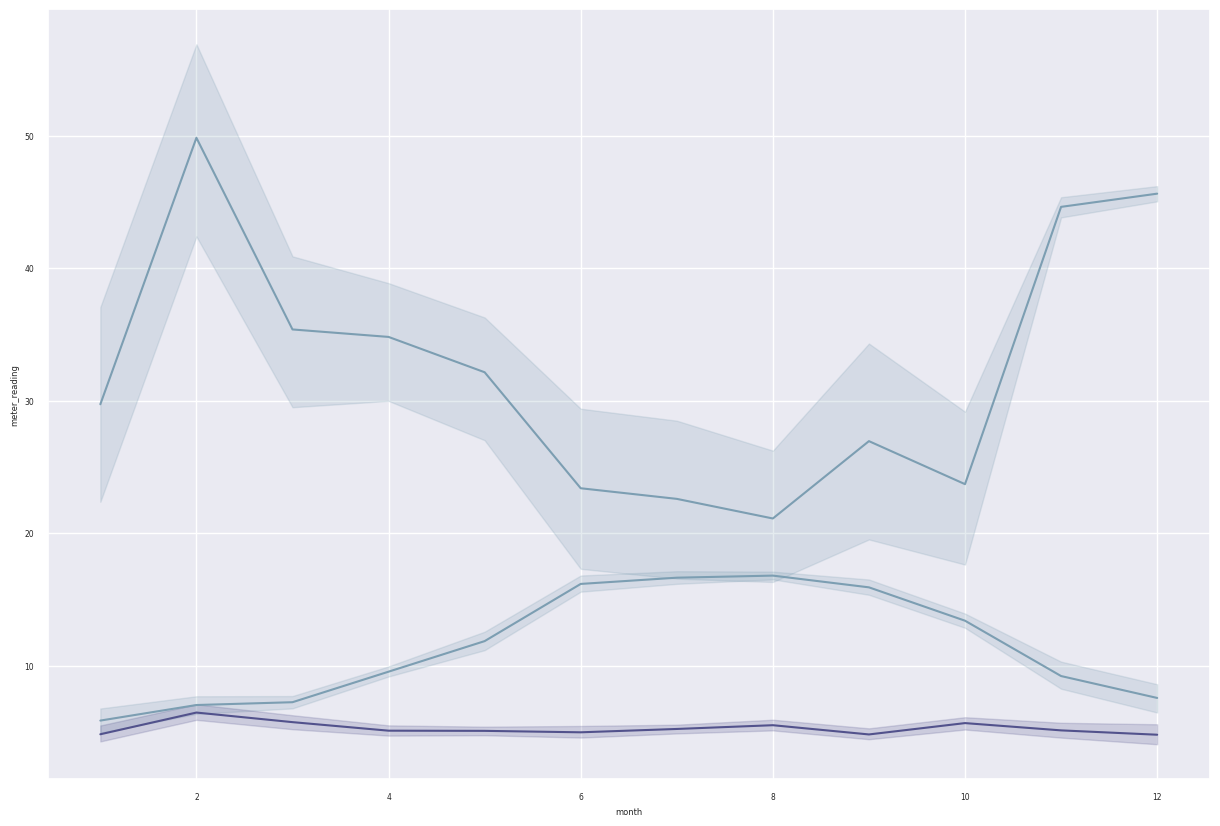

In [95]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
# for bid in full_df["building_id"].unique().tolist()[:10]:
sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==0], 
                x="month", y=target, color=colors[0]/255.)

for j, col in enumerate(["airtemp_mean","windspeed_mean"]):
    sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==0], 
                 x="month", y=col, color=colors[j]/255.)

#### Running model with the new features

In [406]:
X_train, X_valid, Y_train, Y_valid = split_time_data(full_df)

model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.582966370993067


With new ``mean`` features and 1 target shift:

In [407]:
df7 = make_shifts(full_df.drop(columns=[x for x in full_df.columns if "max" in x or "min" in x]), 1)
X_train, X_valid, Y_train, Y_valid = split_time_data(df7)

model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.5925985910360889


With new features and 8 target shifts:

In [408]:
df7 = make_shifts(full_df, 8)
X_train, X_valid, Y_train, Y_valid = split_time_data(df7)

model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.5846987029314702


### 🔮 Predictions 

#### Test data processing

In [379]:
test = pd.read_csv("../kaggle_data/test.csv", index_col=0)

def create_prediction_file(results:list | np.ndarray, results_dir="./"):
    """
    Function that formats predictions and writes them to a .csv file ready for submission.

    :param: results         results to write to the file, list | array
    :param: results_dir     directory to write the results file to, str, default current working directory
                            make sure the directory exists before writing the files there.
    
    """
    csv_fname = "results_{}.csv".format(datetime.now().strftime('%b%d_%H-%M-%S'))
    with open(os.path.join(results_dir, csv_fname), 'w') as f:
        f.write('id, meter_reading\n')
        for i, value in enumerate(results):
            f.write(str(i) + ',' + str(max(0, value)) + '\n')
    return True

In [380]:
test.head()

building_id         day  meter
0            2  2017-11-01    595
1            2  2017-11-01    207
2            2  2017-11-02    595
3            2  2017-11-02    207
4            2  2017-11-03    595

We need to do the same transformations for the test set as we did for the train set, otherwise we will be missing some input features necessary for the model to make predictions:

In [381]:
print("Missing columns:")
set(full_df.columns) - set(test.columns)

Missing columns:


{'airtemp_max',
 'airtemp_mean',
 'airtemp_min',
 'day_number',
 'electricity',
 'gas',
 'heatingtype',
 'hotwater',
 'industry',
 'meter_reading',
 'month',
 'numberoffloors',
 'occupants',
 'primaryspaceusage',
 'rating',
 'site_id',
 'sqm',
 'sub_primaryspaceusage',
 'subindustry',
 'timezone',
 'water',
 'weekday',
 'windspeed_max',
 'windspeed_mean',
 'windspeed_min',
 'year',
 'yearbuilt'}

In [382]:
test = test.merge(metadata, on='building_id', how='left')
test["day"] = test["day"].apply(lambda s: datetime.strptime(s, "%Y-%m-%d"))
test["year"] = test["day"].apply(lambda s: s.year)
test["month"] = test["day"].apply(lambda s: s.month)
test["day_number"] = test["day"].apply(lambda s: s.day)
test["weekday"] = test["day"].apply(lambda s: s.weekday() in [5,6])
test["meter"].replace(meter_dict, inplace=True)

print("Missing columns:")
set(full_df.columns) - set(test.columns)

Missing columns:


{'airtemp_max',
 'airtemp_mean',
 'airtemp_min',
 'meter_reading',
 'windspeed_max',
 'windspeed_mean',
 'windspeed_min'}

#### 🧩 Task IV - Add weather data to the test

In [106]:
# YOUR CODE HERE

In [115]:
test.head()

building_id        day  meter  site_id  primaryspaceusage  \
0            2 2017-11-01      0        0                  1   
1            2 2017-11-01      1        0                  1   
2            2 2017-11-02      0        0                  1   
3            2 2017-11-02      1        0                  1   
4            2 2017-11-03      0        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  hotwater  ...  year  \
0                      4  811.0         1            0         0  ...  2017   
1                      4  811.0         1            0         0  ...  2017   
2                      4  811.0         1            0         0  ...  2017   
3                      4  811.0         1            0         0  ...  2017   
4                      4  811.0         1            0         0  ...  2017   

   month  day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  \
0     11           1    False          9.3         15.7     13.433333   
1     11           1    False          9.3         15.7     13.433333   
2     11           2    False          9.2         15.8     12.687500   
3     11           2    False          9.2         15.8     12.687500   
4     11           3    False          6.1         14.4     11.429167   

   windspeed_min  windspeed_max  windspeed_mean  
0            1.0            7.4        3.925000  
1            1.0            7.4        3.925000  
2            1.3            5.6        3.016667  
3            1.3            5.6        3.016667  
4            1.8            6.0        3.487500  

[5 rows x 29 columns]

#### ⚙️ Solution

In [383]:
test = test.merge(w_df, how="left", on=["day", "site_id"])
test = test.rename(columns=_n)

In [384]:
test.head()

building_id        day  meter  site_id  primaryspaceusage  \
0            2 2017-11-01      0        0                  1   
1            2 2017-11-01      1        0                  1   
2            2 2017-11-02      0        0                  1   
3            2 2017-11-02      1        0                  1   
4            2 2017-11-03      0        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  hotwater  ...  year  \
0                      4  811.0         1            0         0  ...  2017   
1                      4  811.0         1            0         0  ...  2017   
2                      4  811.0         1            0         0  ...  2017   
3                      4  811.0         1            0         0  ...  2017   
4                      4  811.0         1            0         0  ...  2017   

   month  day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  \
0     11           1    False          9.3         15.7     13.433333   
1     11           1    False          9.3         15.7     13.433333   
2     11           2    False          9.2         15.8     12.687500   
3     11           2    False          9.2         15.8     12.687500   
4     11           3    False          6.1         14.4     11.429167   

   windspeed_min  windspeed_max  windspeed_mean  
0            1.0            7.4        3.925000  
1            1.0            7.4        3.925000  
2            1.3            5.6        3.016667  
3            1.3            5.6        3.016667  
4            1.8            6.0        3.487500  

[5 rows x 29 columns]

#### Predictions: lags

To make predictions we would need to generate the shift lags. How do we do it without the target variable readily available?

In [454]:
total_df = pd.concat([full_df, test], ignore_index=True)
print(total_df.shape)
total_df.head()

(291346, 30)


building_id        day  meter  meter_reading  site_id  primaryspaceusage  \
0            2 2016-02-02      0          102.6        0                  1   
1            2 2016-02-02      1            0.3        0                  1   
2            2 2016-02-03      0           88.8        0                  1   
3            2 2016-02-03      1            0.1        0                  1   
4            2 2016-02-04      0           76.3        0                  1   

   sub_primaryspaceusage    sqm  timezone  electricity  ...  year  month  \
0                      4  811.0         1            0  ...  2016      2   
1                      4  811.0         1            0  ...  2016      2   
2                      4  811.0         1            0  ...  2016      2   
3                      4  811.0         1            0  ...  2016      2   
4                      4  811.0         1            0  ...  2016      2   

   day_number  weekday  airtemp_min  airtemp_max  airtemp_mean  windspeed_min  \
0           2    False          8.3         12.0     10.529167            3.2   
1           2    False          8.3         12.0     10.529167            3.2   
2           3    False          5.1         12.8     10.341667            4.7   
3           3    False          5.1         12.8     10.341667            4.7   
4           4    False          3.2         10.8      7.808333            3.1   

   windspeed_max  windspeed_mean  
0           10.2        7.066667  
1           10.2        7.066667  
2            9.5        6.958333  
3            9.5        6.958333  
4            9.5        6.258333  

[5 rows x 30 columns]

❗️ Note that ``meter_reading`` values in the test set are ``NaN``

In [455]:
total_df.tail()

building_id        day  meter  meter_reading  site_id  \
291341          632 2017-12-26      0            NaN        2   
291342          632 2017-12-27      0            NaN        2   
291343          632 2017-12-28      0            NaN        2   
291344          632 2017-12-29      0            NaN        2   
291345          632 2017-12-30      0            NaN        2   

        primaryspaceusage  sub_primaryspaceusage    sqm  timezone  \
291341                 10                      6  914.0         0   
291342                 10                      6  914.0         0   
291343                 10                      6  914.0         0   
291344                 10                      6  914.0         0   
291345                 10                      6  914.0         0   

        electricity  ...  year  month  day_number  weekday  airtemp_min  \
291341            0  ...  2017     12          26    False          6.9   
291342            0  ...  2017     12          27    False          9.6   
291343            0  ...  2017     12          28    False         10.6   
291344            0  ...  2017     12          29    False          8.9   
291345            0  ...  2017     12          30     True          8.8   

        airtemp_max  airtemp_mean  windspeed_min  windspeed_max  \
291341         12.1     10.358333            2.0            6.8   
291342         12.7     11.229167            1.2            9.0   
291343         12.6     11.733333            2.6            9.8   
291344         11.7     10.500000            1.5            8.9   
291345         11.5      9.995833            6.1            9.6   

        windspeed_mean  
291341        4.562500  
291342        5.112500  
291343        6.400000  
291344        5.404167  
291345        7.545833  

[5 rows x 30 columns]

In [456]:
def return_lags(day, bid, meter, shifts):
    """
    Function to generate lags from the existing values and predictions.
    
    day = total_df["day"].iloc[122]

    Our original format was {'lag_{}'.format(ii): Y_train.shift(ii) for ii in shifts}
    """
    # conditions to filter the df on
    res = {}
    for shift in range(shifts):
        try:
            res['lag_{}'.format(shift)] = (total_df.loc[
                (total_df["building_id"]==bid) & 
                (total_df["day"]==day - timedelta(days=int(shift+1))) & 
                (total_df["meter"]==meter)]["meter_reading"].values[0])
        except Exception as e:
            res['lag_{}'.format(shift)] = 0
    return res

In [457]:
# trying out the function
return_lags(test.iloc[0]["day"], test.iloc[0]["building_id"], test.iloc[0]["meter"], shifts=4)

{'lag_0': 0, 'lag_1': 0.1024, 'lag_2': 0.2024, 'lag_3': 0.6023999999999999}

In [458]:
# dataframe of lags of the target
pd.DataFrame(return_lags(test.iloc[0]["day"], test.iloc[0]["building_id"], test.iloc[0]["meter"], shifts=8), index=[0])

lag_0   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7
0      0  0.1024  0.2024  0.6024  0.7024  1.0024  0.4024  0.6024

On one row it looks like this:

In [459]:
row = 0
lags = pd.DataFrame(return_lags(test.iloc[row]["day"], test.iloc[row]["building_id"], test.iloc[row]["meter"], shifts=8), index=[0])
row_to_predict = pd.concat([test.drop(columns=["day"]).iloc[row: row + 1], lags], ignore_index=False, axis=1)

model.predict(row_to_predict) # note: dtype is numpy array, not an integer!

array([0.69504])

Now, let's do it for the entire test set:

In [ ]:
predictions = []

for row in range(test.shape[0]):
    lags = pd.DataFrame(return_lags(test.iloc[row]["day"], test.iloc[row]["building_id"], test.iloc[row]["meter"], shifts=8), index=[0]).fillna(0)
    row_to_predict = pd.concat([test.drop(columns=["day"]).iloc[row: row + 1].reset_index(drop=True), lags.reset_index(drop=True)], ignore_index=False, axis="columns")
    predictions.append(model.predict(row_to_predict)[0])
    total_df.loc[row, "meter_reading"] = predictions[-1]
    if row % 100 == 0:
        print("{}/{} complete".format(row, test.shape[0]))

In [465]:
def create_prediction_file(results:list | np.ndarray, results_dir="./"):
    """
    Function that formats predictions and writes them to a .csv file ready for submission.

    :param: results         results to write to the file, list | array
    :param: results_dir     directory to write the results file to, str, default current working directory
                            make sure the directory exists before writing the files there.
    
    """
    csv_fname = "results_{}.csv".format(datetime.now().strftime('%b%d_%H-%M-%S'))
    with open(os.path.join(results_dir, csv_fname), 'w') as f:
        f.write('id,meter_reading\n')
        for i, value in enumerate(results):
            f.write(str(i) + ',' + str(max(0, value)) + '\n')
    return True

In [466]:
create_prediction_file(predictions)

True

Now we can upload our resulting file to kaggle!

#### 🧩 Task V - trying different models and features

Experiment with different shifts and models, try to find the combination that outperforms the other models and parameters. Have fun!

For inspiration, take a look at these examples:
* [Catboost for time series](https://www.kaggle.com/code/hariprasath1436/time-series-forecasting-with-catboost) - Notebook
* [XGBoost for time series](https://www.youtube.com/watch?v=vV12dGe_Fho) - Video
* [LightGBM for time series](https://medium.com/mlearning-ai/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee) - article + code

### 🧬 Resources

* [XGBoost with Time Series](https://www.youtube.com/watch?v=vV12dGe_Fho)
* [Catboost for time series](https://www.kaggle.com/code/hariprasath1436/time-series-forecasting-with-catboost)
* [LightGBM for time series](https://medium.com/mlearning-ai/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee)
* [mlcourse.ai](https://mlcourse.ai/book/index.html)
* [Visualizing Time Series Data in Python - Datacamp](https://app.datacamp.com/learn/courses/visualizing-time-series-data-in-python)
* [ML for Time Series Data in Python - Datacamp](https://app.datacamp.com/learn/courses/machine-learning-for-time-series-data-in-python)
* [A bit more profound explanation of autoregression](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)